# Plot exoplanet lightcurves
This notebook builds upon the Downloading Exoplanet Data notebook. (link?)

***

# Learning Goals

By the end of this tutorial, you will:

- Understand different methods of plotting light curves.
- Effectively use `matplotlib`.
- Become familiar with the `lightkurve` API.
- Become familiar with the FITS file format.

# Introduction

Light curves — which track the brightness of an object over time — are a crucial data product for studying exoplanets. They are used to constrain properties as fundamental as planetary size and as complex as atmospheric circulation.

Plotting light curves is a crucial intermediate data-processing step, taken in advance of any specific science case steps. Doing so can verify that noise levels are as expected and that data processing tools have been applied correctly.

In this tutorial, we will explore how to plot light curves via two methods: direct MAST API queries and with the [lightkurve](https://docs.lightkurve.org/) package. We will focus on isolating the characteristic "U shape" caused by a planet passing in front of its host star during its [transit](https://exoplanets.nasa.gov/faq/31/whats-a-transit/#:~:text=Most%20known%20exoplanets%20have%20been,between%20us%20and%20the%20Sun.). 


This tutorial assumes familiarity with the `download_exoplanet_data` notebook.

# Imports 
- sys (Python builtin) to read our machine's Python version.
- os (Python builtin) to create directories for downloaded data and to manage paths.
- json (Python builtin) to load results from HTTP requests.
- pprint (Python builtin) to neatly print json outputs.
- urllib (Python builtin) to submit HTTP requests and interact with the exo.MAST API.
- numpy to help aggregate our metadata
- requests to make HTTPS requests to MAST servers.
- astropy to provide data structures that organize our metadata.
- lightkurve to download light curves with a different API (change).
- matplotlib to plot the light curves.

In [3]:
import sys
import os
import json
import pprint
from urllib.parse import quote as urlencode

import numpy as np
import requests
from astropy.table import Table
import lightkurve

import matplotlib.pyplot as plt
import astropy.io.fits as fits
from matplotlib import rc

# Method 1: MAST API
With this method, we will directly interface with the MAST API to retrieve light curve data and plot it with matplotlib. We will use a similar approach to the `download_exoplanet_data` notebook.

Before we get started, we use the `pprint` package to make sure that any printed json data is cleanly represented.

In [58]:
pp = pprint.PrettyPrinter(indent=4)

Next, we select our target, create a request, and encode the request so that we can submit it to MAST API.

In [23]:
object_of_interest = 'WASP-12 b'

resolver_request = {'service':'Mast.Name.Lookup',
                     'params':{'input':object_of_interest,
                               'format':'json'},
                     }

# encoding the request as a json string
req_string = json.dumps(resolver_request)
req_string = urlencode(req_string)

# create HTTP Header Variables
headers = {"Content-type": "application/x-www-form-urlencoded",
           "Accept": "text/plain"}

With our request in hand, we can now use the MAST API to gather basic metadata on our target, suxh as its coordinates. 

In [25]:
# base API url
request_url='https://mast.stsci.edu/api/v0/invoke'    

# perform the HTTP request
resp = requests.post(request_url, data="request="+req_string, headers=headers)

resolved_object = resp.json()

The target coordinates are represented in the dictionary structure of `resolved_object`. 

In [27]:
obj_ra = resolved_object['resolvedCoordinate'][0]['ra']
obj_dec = resolved_object['resolvedCoordinate'][0]['decl']

Next, we can search around this target's RA and Dec to retrieve a list of observations that have been taken for the target. A 5 arcsecond search radius should be more than enough to overlap with our target.

In [28]:
search_radius = 5 / 3600 # convert from arcseconds to degrees.

mast_request = {'service':'Mast.Caom.Cone',
                'params':{'ra':obj_ra,
                          'dec':obj_dec,
                          'radius':search_radius},
                'format':'json',
                'pagesize':2000,
                'page':1,
                'removenullcolumns':True,
                'removecache':True}


# encoding the request as a json string
req_string = json.dumps(mast_request)
req_string = urlencode(req_string)

# perform the HTTP request
resp = requests.post(request_url, data="request="+req_string, headers=headers)

# decode the HTTP result
mast_data = resp.json()

The `mast_data` object is a bit difficult to parse, so let's recast it as an Astropy `Table`.

In [29]:
mast_data_table = Table()

col_type_list = [(field['name'], field['type']) for field in mast_data['fields']]

for col, atype in col_type_list:
    
    # recast data types
    if atype=="string":
        atype="str"
    if atype=="boolean":
        atype="bool"
    
    # create column in Table corresponding to the mast_data field
    mast_data_table[col] = np.array([x.get(col, None) for x in mast_data['data']],dtype=atype)

Let's grab the most recent observation. To do so, we'll sort by the minimum time of the observation and access the last entry in the newly sorted table.

In [30]:
mast_data_table.sort('t_min')

recent_index = -1
interesting_observation = mast_data_table[mast_data_table["project"] == "TESS"][recent_index]
print("Observation:",
      [interesting_observation[x] for x in ['dataproduct_type', 'obs_collection', 'instrument_name']])

With our observation selected, we can query MAST once more for a list of data products corresponding to the observation. 

In [56]:
obsid = interesting_observation['obsid']

product_request = {'service':'Mast.Caom.Products',
                  'params':{'obsid':obsid},
                  'format':'json',
                  'pagesize':100,
                  'page':1,
                  'productType':'SCIENCE'}   

# encoding the request as a json string
req_string = json.dumps(product_request)
req_string = urlencode(req_string)

# perform the HTTP request
resp = requests.post(request_url, data="request="+req_string, headers=headers)

# dfrecode the HTTP result
obs_products = resp.json()

Once more, we recast this object as a `Table` (keeping only the `SCIENCE` data products).

In [33]:
sci_prod_arr = [x for x in obs_products['data'] if x.get("productType", None) == 'SCIENCE']
science_products = Table()

col_type_list = [(field['name'], field['type']) for field in obs_products['fields']]

for col, atype in col_type_list:
    
    # recast data types
    if atype=="string":
        atype="str"
    if atype=="boolean":
        atype="bool"
    if atype == "int":
        atype = "float" # array may contain nan values, and they do not exist in numpy integer arrays
        
    # Create column in Table corresponding to the mast_data field
    science_products[col] = np.array([x.get(col,None) for x in sci_prod_arr],dtype=atype)

Now, we can loop through the `Table`, downloading the actual data products themselves.

In [34]:
download_url = 'https://mast.stsci.edu/api/v0.1/Download/file?'

for row in science_products:     

    # Make file path
    out_path = os.path.join("mastFiles", row['obs_collection'], row['obs_id'])
    if not os.path.exists(out_path):
        os.makedirs(out_path)
    out_path = os.path.join(out_path, os.path.basename(row['productFilename']))
        
    # Download the data
    payload = {"uri":row['dataURI']}
    resp = requests.get(download_url, params=payload)
    
    # Save to file
    with open(out_path,'wb') as f:
        f.write(resp.content)
        
    # Check for file 
    if not os.path.isfile(out_path):
        print("ERROR: " + out_path + " failed to download.")
    else:
        print("COMPLETE: ", out_path)

COMPLETE:  mastFiles/TESS/tess2021310001228-s0045-0000000086396382-0216-s/tess2021311000057-s0045-s0045-0000000086396382-00542_dvt.fits
COMPLETE:  mastFiles/TESS/tess2021310001228-s0045-0000000086396382-0216-s/tess2021310001228-s0045-0000000086396382-0216-s_lc.fits
COMPLETE:  mastFiles/TESS/tess2021310001228-s0045-0000000086396382-0216-s/tess2021310001228-s0045-0000000086396382-0216-s_tp.fits


Now, as before, we've downloaded our data. But how do we plot it?

Firstly, we need to load the data in. Note that the downloaded files are in the FITS (Flexible Image Transport System) file format. FITS files are commonly used in astronomy, as its name implies, to transport images. However, their usage has expanded beyond images into general astronomical data over the years. FITS files can seem a bit tricky to work with at first — for instance, you can't easily view the data within a FITS file as if it were a text file. To help us read in FITS data, we'll make use of the `astropy` modules that were built for FITS functionality.


Because we're interested in plotting light curves, we'll select the downloaded file that ends with "lc", shorthand for "light curve".

In [35]:
filename = 'mastFiles/TESS/tess2021310001228-s0045-0000000086396382-0216-s/' \
                    + 'tess2021310001228-s0045-0000000086396382-0216-s_lc.fits'


Before we access the actual data, we can check the *header* of the FITS file. FITS headers contain useful metadata, such as units and timestamps, that may help later analysis.

In [36]:
fits.getheader(filename)

SIMPLE  =                    T / conforms to FITS standards                     
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T / file contains extensions                       
NEXTEND =                    2 / number of standard extensions                  
EXTNAME = 'PRIMARY '           / name of extension                              
EXTVER  =                    1 / extension version number (not format version)  
SIMDATA =                    F / file is based on simulated data                
ORIGIN  = 'NASA/Ames'          / institution responsible for creating this file 
DATE    = '2021-12-10'         / file creation date.                            
TSTART  =    2525.527182975455 / observation start time in BTJD                 
TSTOP   =    2550.630123578529 / observation stop time in BTJD                  
DATE-OBS= '2021-11-07T00:37:

Next, we can use the `getdata` function within `astropy.io.fits` to straightforwardly access the FITS data.

In [37]:
data = fits.getdata(filename)
data

FITS_rec([(2525.50565341, 0.0035128 , 934594,       nan,      nan,       nan,       nan,       nan,        nan, 168, nan, nan, nan, nan,          nan,        nan,           nan,        nan,        nan,        nan),
          (2525.5070424 , 0.00351291, 934595,       nan,      nan,       nan,       nan,       nan,        nan,  32, nan, nan, nan, nan,          nan,        nan,           nan,        nan,        nan,        nan),
          (2525.5084314 , 0.00351302, 934596,       nan,      nan,       nan,       nan,       nan,        nan,  32, nan, nan, nan, nan,          nan,        nan,           nan,        nan,        nan,        nan),
          ...,
          (2550.62665134, 0.00507747, 952680, 5160.6455, 9.678564, 1787.9225, 3.523898 , 6058.958 , 11.548166 ,   0, nan, nan, nan, nan, 991.46046597, 0.00143142, 1238.40788105, 0.00129935, 0.02054205, 0.05611402),
          (2550.62804028, 0.00507752, 952681, 5166.788 , 9.686514, 1788.695 , 3.5262184, 6067.0127, 11.5576515,   0, nan, nan

The data re reported as a `FITS_rec`; this is a special data type that allows for heterogenous data types to coexist in a single object. Note that there are individual data types listed after `dtype` that describe the different data types in the FITS data.

Let's access a single row to get a sense of how these data are structured.

In [38]:
data[0], len(data[0])

((2525.5056534058176, 0.003512804, 934594, nan, nan, nan, nan, nan, nan, 168, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan),
 20)

In [39]:
data.dtype

dtype((numpy.record, [('TIME', '>f8'), ('TIMECORR', '>f4'), ('CADENCENO', '>i4'), ('SAP_FLUX', '>f4'), ('SAP_FLUX_ERR', '>f4'), ('SAP_BKG', '>f4'), ('SAP_BKG_ERR', '>f4'), ('PDCSAP_FLUX', '>f4'), ('PDCSAP_FLUX_ERR', '>f4'), ('QUALITY', '>i4'), ('PSF_CENTR1', '>f8'), ('PSF_CENTR1_ERR', '>f4'), ('PSF_CENTR2', '>f8'), ('PSF_CENTR2_ERR', '>f4'), ('MOM_CENTR1', '>f8'), ('MOM_CENTR1_ERR', '>f4'), ('MOM_CENTR2', '>f8'), ('MOM_CENTR2_ERR', '>f4'), ('POS_CORR1', '>f4'), ('POS_CORR2', '>f4')]))

We can see that each element in data is a iterable with 20 elements, each of the corresponding data type returned by `data.dtype`.

While this format of data is useful, an `astropy Table` would be even better for slicing and manipulating data. Turning these FITS data into a `Table` will require a bit of code.

Firstly, we need to create a list of our `Table`'s columns.

In [40]:
cols = data.dtype.names
cols

('TIME',
 'TIMECORR',
 'CADENCENO',
 'SAP_FLUX',
 'SAP_FLUX_ERR',
 'SAP_BKG',
 'SAP_BKG_ERR',
 'PDCSAP_FLUX',
 'PDCSAP_FLUX_ERR',
 'QUALITY',
 'PSF_CENTR1',
 'PSF_CENTR1_ERR',
 'PSF_CENTR2',
 'PSF_CENTR2_ERR',
 'MOM_CENTR1',
 'MOM_CENTR1_ERR',
 'MOM_CENTR2',
 'MOM_CENTR2_ERR',
 'POS_CORR1',
 'POS_CORR2')

Next, we need to format the data into a single `numpy array`, so that we can pass it to the `Table` constructor.

In [41]:
# create an empty list for the formatted data
data_formatted = []

# iterate through data and add each row to the list
for row in data:
    data_formatted += [list(row)]
    
data_formatted = np.array(data_formatted)

In [42]:
data_table = Table(data_formatted,
            names=cols)

In [43]:
data_table

TIME,TIMECORR,CADENCENO,SAP_FLUX,SAP_FLUX_ERR,SAP_BKG,SAP_BKG_ERR,PDCSAP_FLUX,PDCSAP_FLUX_ERR,QUALITY,PSF_CENTR1,PSF_CENTR1_ERR,PSF_CENTR2,PSF_CENTR2_ERR,MOM_CENTR1,MOM_CENTR1_ERR,MOM_CENTR2,MOM_CENTR2_ERR,POS_CORR1,POS_CORR2
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
2525.5056534058176,0.0035128039307892323,934594.0,nan,nan,nan,nan,nan,nan,168.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2525.5070424025885,0.003512912429869175,934595.0,nan,nan,nan,nan,nan,nan,32.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2525.508431399592,0.0035130211617797613,934596.0,nan,nan,nan,nan,nan,nan,32.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2525.5098203965954,0.0035131298936903477,934597.0,nan,nan,nan,nan,nan,nan,160.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2525.511209393366,0.0035132383927702904,934598.0,nan,nan,nan,nan,nan,nan,144.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2525.512598390368,0.0035133471246808767,934599.0,nan,nan,nan,nan,nan,nan,16.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2525.5139873873713,0.003513455856591463,934600.0,nan,nan,nan,nan,nan,nan,16.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2525.5153763843737,0.0035135645885020494,934601.0,nan,nan,nan,nan,nan,nan,16.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2525.516765381377,0.003513673320412636,934602.0,nan,nan,nan,nan,nan,nan,144.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


Now, we have a `Table` containing all our light curve data — this can be used to plot our data.

To plot the data, we set x values, y values, and y error values from our table and pass these values to the `plt.errorbar` command. Our x values are in offset BTJD (Barycentric TESS Julian Date) days, and our y values are flux as represented in electrons per second.

We'll start by using the `SAP_FLUX` (simple aperture photometry flux) column as our y values. These are essentially the raw TESS data, uncorrected for any long-term trends.


For our y label, we will use a [LaTeX](https://www.latex-project.org/) string to achieve cleaner formatting for exponents.

Text(0, 0.5, 'Flux $\\rm [e^{-1}s^{-1}]$')

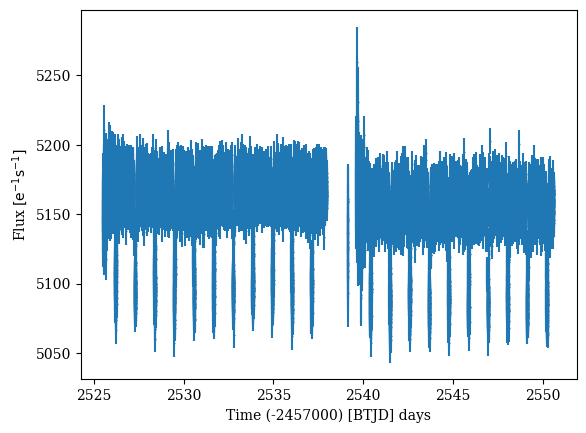

In [47]:
x_values = data_table['TIME']
y_values = data_table['SAP_FLUX']
y_err_values = data_table['SAP_FLUX_ERR']

ms = 1 # set the marker size to 1
fmt = '.' # plot individual points without a connecting line

plt.errorbar(x_values, y_values, y_err_values, ms=ms, fmt=fmt)
plt.xlabel('Time (-2457000) [BTJD] days')
plt.ylabel(r'Flux $\rm [e^{-1}s^{-1}]$')

The downward spikes that we see are transits of our selected planet. Note that the transits have different depths here in large part because of data error; for light curves taken with a lower cadence, further difference in transit depths can creep up due to not "catching" the deepest center of transit. 

Let's zoom in on a transit so we can get a better sense of the data quality.

(5050.0, 5225.0)

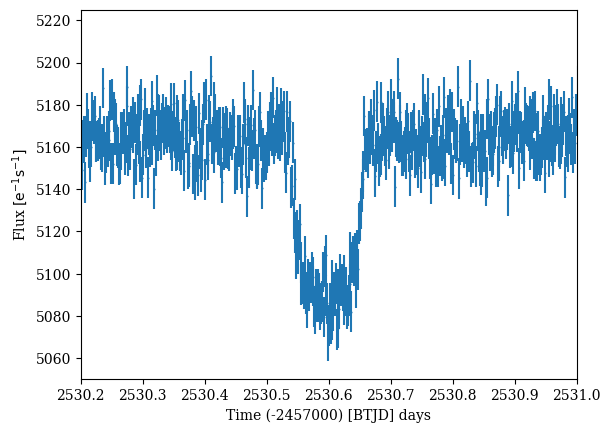

In [49]:
plt.errorbar(data_table['TIME'], data_table['SAP_FLUX'], data_table['SAP_FLUX_ERR'], ms=1, fmt='.')
plt.xlabel('Time (-2457000) [BTJD] days')
plt.ylabel(r'Flux $\rm [e^{-1}s^{-1}]$') 

plt.xlim(2530.2, 2531)
plt.ylim(5050, 5225)

This is a pretty clean transit! We can see the expected U-like shape due to limb-darkening (explain), and the light curve looks relatively flat outside of transit. 

(do: quick check to see whether the transit depth lines up with expectations?)

(also, are the error bars what we'd expect? is the RMS what we'd expect based on the error bars? histogram them, and do a statistic?)

Let's next take a look at the `PDCSAP_FLUX` (pre-search data conditiong simple aperture photometry flux) column. This column's data has been cleaned by the TESS team to enable robust planet-finding. For instance, in these these data, some of the long-term data trends have been removed using a technique known as [Cotrending Basis Vectors](https://docs.lightkurve.org/tutorials/2-creating-light-curves/2-2-how-to-use-cbvs.html#:~:text=Cotrending%20Basis%20Vectors%20(CBVs)%20are,K2%20and%20Sector%20for%20TESS).

Text(0, 0.5, 'Flux $\\rm [e^{-1}s^{-1}]$')

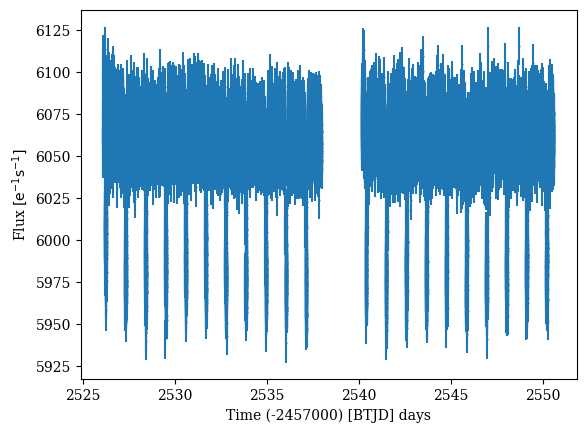

In [51]:
plt.errorbar(data_table['TIME'], data_table['PDCSAP_FLUX'], data_table['PDCSAP_FLUX_ERR'], ms=1, fmt='.')

plt.xlabel('Time (-2457000) [BTJD] days')
plt.ylabel(r'Flux $\rm [e^{-1}s^{-1}]$') 

As expected, these data look a little cleaner than the `SAP_FLUX` data. The spike after the data gap in the `SAP_FLUX` plot is gone, for instance.

Again, let's zoom in on a single transit.

(2530.2, 2531.0)

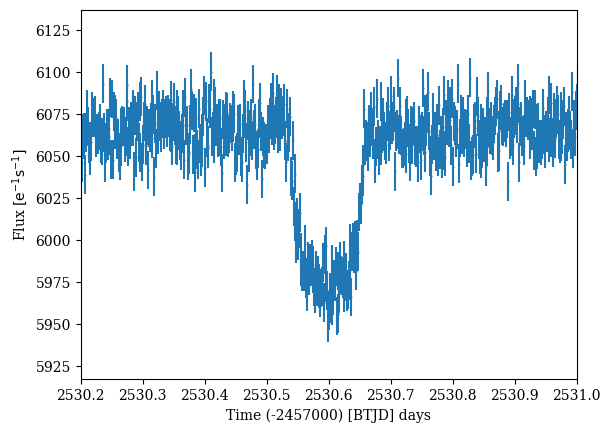

In [52]:
plt.errorbar(data_table['TIME'], data_table['PDCSAP_FLUX'], data_table['PDCSAP_FLUX_ERR'], ms=1, fmt='.')

plt.xlabel('Time (-2457000) [BTJD] days')
plt.ylabel(r'Flux $\rm [e^{-1}s^{-1}]$')

plt.xlim(2530.2, 2531)

For our final plot, we'll change the font, adjust the figure size, and change the color of the plot. This step makes it easier to see the data and make it more "publication-ready" — e.g., have label fonts that are an acceptable size for a manuscript.

In [53]:
rc('font', family='serif',
                  style='normal', variant='normal',
                  stretch='normal', weight='normal')

(2530.2, 2531.0)

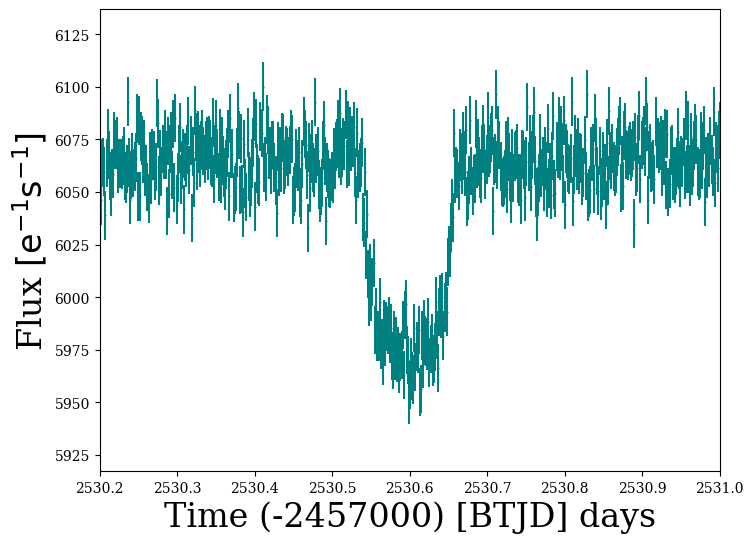

In [55]:
plt.figure(figsize=(8,6))
plt.errorbar(data_table['TIME'], data_table['PDCSAP_FLUX'], data_table['PDCSAP_FLUX_ERR'], 
             ms=1, fmt='.', color='teal')

plt.xlabel('Time (-2457000) [BTJD] days', fontsize=24)

plt.ylabel(r'Flux $\rm [e^{-1}s^{-1}]$', fontsize=24) 

plt.xlim(2530.2, 2531)
# plt.ylim(5050, 5225)

# Method 2: lightkurve
 For our second method, we'll download and plot light curves with the [`lightkurve` package](https://docs.lightkurve.org/index.html). `lightkurve` is a `Python` package made for analyzing the time series of planets, stars, and galaxies.


This portion of the tutorial is inspired by the [lightkurve documentation](https://docs.lightkurve.org/tutorials/1-getting-started/searching-for-data-products.html).

Our first step is to search for data on our planet using the `search_lightcurve` function.

In [72]:
search_result = lightkurve.search_lightcurve('WASP-12 b')
search_result

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 20,2019,SPOC,120,86396382,0.0
1,TESS Sector 20,2019,TESS-SPOC,1800,86396382,0.0
2,TESS Sector 20,2019,QLP,1800,86396382,0.0
3,TESS Sector 20,2019,CDIPS,1800,86396382,0.0
4,TESS Sector 43,2021,SPOC,120,86396382,0.0
5,TESS Sector 44,2021,SPOC,120,86396382,0.0
6,TESS Sector 45,2021,SPOC,120,86396382,0.0


We can see that there are a number of different data products available. Let's download the latest SPOC one, using the `.download` method.

In [73]:
lightcurve = search_result[6].download()
lightcurve

time,flux,flux_err,timecorr,cadenceno,centroid_col,centroid_row,sap_flux,sap_flux_err,sap_bkg,sap_bkg_err,pdcsap_flux,pdcsap_flux_err,quality,psf_centr1,psf_centr1_err,psf_centr2,psf_centr2_err,mom_centr1,mom_centr1_err,mom_centr2,mom_centr2_err,pos_corr1,pos_corr2
,electron / s,electron / s,d,,pix,pix,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,,pix,pix,pix,pix,pix,pix,pix,pix,pix,pix
Time,float32,float32,float32,int32,float64,float64,float32,float32,float32,float32,float32,float32,int32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32
2525.512598390368,———,———,3.5133471e-03,934599,———,———,———,———,———,———,———,———,10000,———,———,———,———,———,———,———,———,———,———
2525.5139873873713,———,———,3.5134559e-03,934600,———,———,———,———,———,———,———,———,10000,———,———,———,———,———,———,———,———,———,———
2525.5153763843737,———,———,3.5135646e-03,934601,———,———,———,———,———,———,———,———,10000,———,———,———,———,———,———,———,———,———,———
2525.51815437838,———,———,3.5137821e-03,934603,———,———,———,———,———,———,———,———,10000,———,———,———,———,———,———,———,———,———,———
2525.519543375616,———,———,3.5138910e-03,934604,———,———,———,———,———,———,———,———,10000,———,———,———,———,———,———,———,———,———,———
2525.5223213696217,———,———,3.5141085e-03,934606,———,———,———,———,———,———,———,———,10000,———,———,———,———,———,———,———,———,———,———
2525.541767330924,———,———,3.5156340e-03,934620,991.43393,1238.37648,5.1394507e+03,1.8788059e+01,1.7122324e+04,9.9545498e+00,———,———,1000000000000,———,———,———,———,991.43393,2.9528276e-03,1238.37648,2.6476730e-03,-1.1913789e-02,1.6894253e-02
2525.5431563283923,———,———,3.5157432e-03,934621,991.43201,1238.36379,5.1479922e+03,1.8715607e+01,1.6962000e+04,9.9084806e+00,———,———,1000000000000,———,———,———,———,991.43201,2.9379919e-03,1238.36379,2.6328138e-03,-1.0140752e-02,-1.3248989e-03


With this object, we can plot with a single command.

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

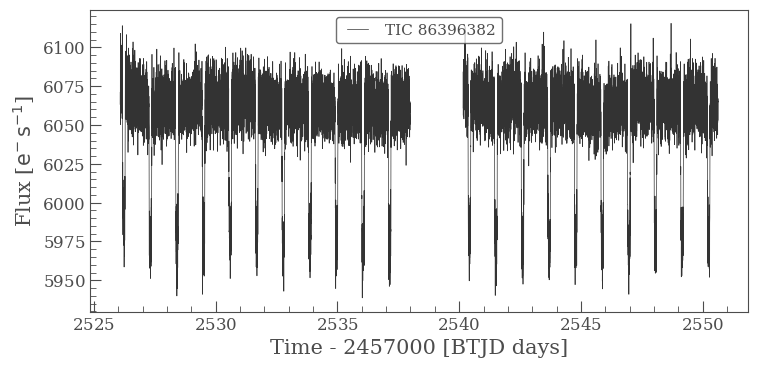

In [30]:
lightcurve.plot()

Once again, the transits are clearly evident. We can restrict ourselves to a single transit.

(2529.0, 2530.0)

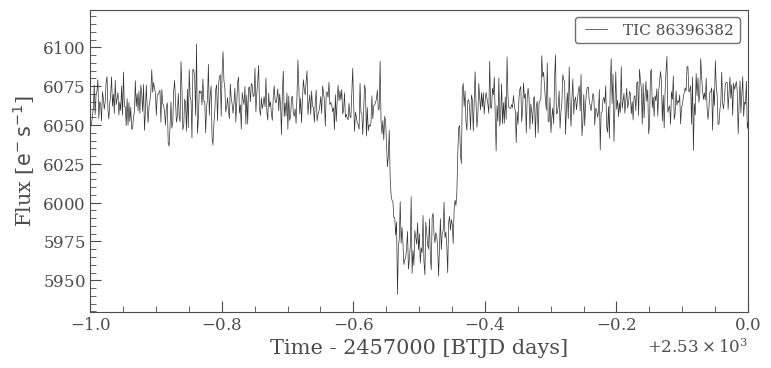

In [31]:
lightcurve.plot()
plt.xlim(2529, 2530)

# Exercises
1. Plot the light curve of WASP-76 b.
2. Combine the light curves of data from two different sectors.
3. Plot the transits of planets orbiting stars of very different temperatures. See if you can isolate differences in limb darkening for these transits (the sloping down and up at the beginning and end of the transit).

# Citations
If you use `astropy`, `matplotlib`, `numpy`, or `lightkurve` for published research, please cite the
authors. Follow these links for more information about citing `astropy`,
`matplotlib`, `numpy`, and `lightkurve`:

* [Citing `astropy`](https://www.astropy.org/acknowledging.html)
* [Citing `matplotlib`](https://matplotlib.org/stable/users/project/citing.html)
* [Citing `numpy`](https://numpy.org/citing-numpy/)
* [Citing `lightkurve`](https://docs.lightkurve.org/about/citing.html)


# Additional Resources
- An [introduction to HTTP GET requests](https://www.ibm.com/docs/en/cics-ts/5.3?topic=protocol-http-requests).
- Information on the [TESS Mission](https://tess.mit.edu/).
- [Library of Congress resource on FITS files](https://www.loc.gov/preservation/digital/formats/fdd/fdd000317.shtml#:~:text=FITS%20is%20a%20file%20format,as%20pictures%20to%20look%20at.)
- [FITS data primer](https://fits.gsfc.nasa.gov/fits_primer.html)
- [Astropy tutorial on FITS image manipulation](https://learn.astropy.org/tutorials/FITS-images.html)
- [Prettyprint documentation](https://docs.python.org/3/library/pprint.html)
- [MAST API documentation](https://mast.stsci.edu/api/v0/MastApiTutorial.html)
- [Wikipedia entry for limb darkening](https://en.wikipedia.org/wiki/Limb_darkening)
- [Matplotlib tutorials](https://matplotlib.org/stable/tutorials/index.html)
- [Some Matplotlib tricks](https://www.analyticsvidhya.com/blog/2020/05/10-matplotlib-tricks-data-visualization-python/)

# About this Notebook

**Last updated**: 2022-07-24

For support, contact archive@stsci.edu

[Top of Page](#top)<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/>
